# Data science Capstone Project

# Initiating the connection with pyspark

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\Spark\\spark-3.1.1-bin-hadoop2.7'

In [2]:
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import*

In [3]:
from pyspark.sql import SparkSession
conf=pyspark.SparkConf().setAppName('SparkApp').setMaster('local')
sc=pyspark.SparkContext(conf=conf)
spark=SparkSession(sc)

In [4]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [5]:
spark = SparkSession.Builder().getOrCreate()

# Classification Problem
## Reading the dataset and preprocessing it

In [6]:
flightSchema = StructType([
  StructField("DayofMonth", IntegerType(), False),
  StructField("DayOfWeek", IntegerType(), False),
  StructField("Carrier", StringType(), False),
  StructField("OriginAirportID", IntegerType(), False),
  StructField("DestAirportID", IntegerType(), False),
  StructField("DepDelay", IntegerType(), False),
  StructField("ArrDelay", IntegerType(), False),
])

flights = spark.read.csv('dataset/raw-flight-data.csv', 
                         schema=flightSchema, header=True)
flights.show(10)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|        19|        5|     DL|          11433|        13303|      -3|       1|
|        19|        5|     DL|          14869|        12478|       0|      -8|
|        19|        5|     DL|          14057|        14869|      -4|     -15|
|        19|        5|     DL|          15016|        11433|      28|      24|
|        19|        5|     DL|          11193|        12892|      -6|     -11|
|        19|        5|     DL|          10397|        15016|      -1|     -19|
|        19|        5|     DL|          15016|        10397|       0|      -1|
|        19|        5|     DL|          10397|        14869|      15|      24|
|        19|        5|     DL|          10397|        10423|      33|      34|
|        19|        5|     DL|          11278|      

In [7]:
airportSchema = StructType([
  StructField("airport_id", IntegerType(), False),
  StructField("city", StringType(), False),
  StructField("state", StringType(), False),
  StructField("name", StringType(), False),
])

airports = spark.read.csv('dataset/airports.csv', header=True, 
                          schema=airportSchema)
airports.show(10)

+----------+-----------+-----+--------------------+
|airport_id|       city|state|                name|
+----------+-----------+-----+--------------------+
|     10165|Adak Island|   AK|                Adak|
|     10299|  Anchorage|   AK|Ted Stevens Ancho...|
|     10304|      Aniak|   AK|       Aniak Airport|
|     10754|     Barrow|   AK|Wiley Post/Will R...|
|     10551|     Bethel|   AK|      Bethel Airport|
|     10926|    Cordova|   AK|Merle K Mudhole S...|
|     14709|  Deadhorse|   AK|   Deadhorse Airport|
|     11336| Dillingham|   AK|  Dillingham Airport|
|     11630|  Fairbanks|   AK|Fairbanks Interna...|
|     11997|   Gustavus|   AK|    Gustavus Airport|
+----------+-----------+-----+--------------------+
only showing top 10 rows



+ Merge two dataFrame (flight and airports), and show how many flights from each City

In [8]:
flightsByOrigin = flights.join(airports,
                               flights.OriginAirportID == 
                               airports.airport_id).groupBy("city").count()
flightsByOrigin.show(3)

+--------------+-----+
|          city|count|
+--------------+-----+
|       Phoenix|90281|
|         Omaha|13537|
|Raleigh/Durham|28436|
+--------------+-----+
only showing top 3 rows



+ **Removing Duplicate data**

In [9]:
#count the number of original data rows
n1 = flights.count()
print("number of original data rows: ", n1)
#count the number of data rows after deleting duplicated data
n2 = flights.dropDuplicates().count()
print("number of data rows after deleting duplicated data: ", n2)
n3 = n1 - n2
print("number of duplicated data: ", n3)

number of original data rows:  2719418
number of data rows after deleting duplicated data:  2696983
number of duplicated data:  22435


In [10]:
flights =  flights.dropDuplicates()
n4 = flights.count()
print(n4)

2696983


+ Duplicate entries successively removed

+ **Handline missing data**

In [11]:
flights.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flights.columns]).show()

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|         0|        0|      0|              0|            0|   22209|   23798|
+----------+---------+-------+---------------+-------------+--------+--------+



In [12]:
flightsNoMissingValue = flights.dropna(
    how="any", subset=["ArrDelay", "DepDelay"])# use how="all" for all column missing data
numberOfMissingValueAny = n1 - flightsNoMissingValue.count()

print("number of missing value rows: ", numberOfMissingValueAny)

number of missing value rows:  46233


In [13]:
#take mean value
meanArrDelay = flights.groupBy().avg("ArrDelay").take(1)[0][0]
print("mean ArrDelay: ", meanArrDelay)
meanDepDelay = flights.groupBy().avg("DepDelay").take(1)[0][0]
print("mean DepDelay: ", meanDepDelay)
#drop duplicated data and fill missing data with mean value
flightsCleanData=flights.fillna(
    {'ArrDelay': meanArrDelay, 'DepDelay': meanDepDelay})
#just for experiment
flights.groupBy().avg("ArrDelay").show()

mean ArrDelay:  6.7272897311633875
mean DepDelay:  10.618575625454712
+------------------+
|     avg(ArrDelay)|
+------------------+
|6.7272897311633875|
+------------------+



In [14]:
flightsCleanData.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in flightsCleanData.columns]).show()

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|         0|        0|      0|              0|            0|       0|       0|
+----------+---------+-------+---------------+-------------+--------+--------+



+ Successively replaced the null values with the means of the column

+ we have removed any duplicate entries and also handled missing entries

+ Displaying cleaned data and its statistics

In [15]:
flightsCleanData.show(10)

+----------+---------+-------+---------------+-------------+--------+--------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|
+----------+---------+-------+---------------+-------------+--------+--------+
|         2|        1|     WN|          12889|        10140|      -1|       7|
|         6|        1|     WN|          10821|        10140|       1|     -22|
|         8|        1|     AA|          11298|        10140|       0|       6|
|         8|        1|     MQ|          12892|        10140|       0|       9|
|        15|        1|     WN|          11259|        10140|      21|      20|
|        15|        1|     WN|          14747|        10140|      -6|       3|
|        17|        1|     WN|          12889|        10140|      -4|      -9|
|        19|        1|     EV|          12266|        10140|      -5|     -15|
|        21|        1|     AA|          11298|        10140|      63|      54|
|        26|        1|     DL|          10397|      

In [16]:
flightsCleanData.describe('DepDelay','ArrDelay').show()

+-------+------------------+------------------+
|summary|          DepDelay|          ArrDelay|
+-------+------------------+------------------+
|  count|           2696983|           2696983|
|   mean|10.613481805409972|  6.72087217457433|
| stddev| 36.04900147972999|38.578791794541594|
|    min|               -63|               -94|
|    max|              1863|              1845|
+-------+------------------+------------------+



In [17]:
from pyspark.ml.feature import StringIndexer #this is used to label encode our data
indexer = StringIndexer(inputCol="Carrier", outputCol="carrierIndex")
encodedFlightData =  indexer.fit(flightsCleanData).transform(flightsCleanData)
encodedFlightData.show()

+----------+---------+-------+---------------+-------------+--------+--------+------------+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|carrierIndex|
+----------+---------+-------+---------------+-------------+--------+--------+------------+
|         2|        1|     WN|          12889|        10140|      -1|       7|         0.0|
|         6|        1|     WN|          10821|        10140|       1|     -22|         0.0|
|         8|        1|     AA|          11298|        10140|       0|       6|         2.0|
|         8|        1|     MQ|          12892|        10140|       0|       9|         8.0|
|        15|        1|     WN|          11259|        10140|      21|      20|         0.0|
|        15|        1|     WN|          14747|        10140|      -6|       3|         0.0|
|        17|        1|     WN|          12889|        10140|      -4|      -9|         0.0|
|        19|        1|     EV|          12266|        10140|      -5|     -15|  

+ As shown above the last column is an encoded version of the Carrier column
+ now we will drop the column with string values and display the **Cleaned Dataset**

In [18]:
FinalCleanedFlightData = encodedFlightData.drop("Carrier")
FinalCleanedFlightData.show(5)

+----------+---------+---------------+-------------+--------+--------+------------+
|DayofMonth|DayOfWeek|OriginAirportID|DestAirportID|DepDelay|ArrDelay|carrierIndex|
+----------+---------+---------------+-------------+--------+--------+------------+
|         2|        1|          12889|        10140|      -1|       7|         0.0|
|         6|        1|          10821|        10140|       1|     -22|         0.0|
|         8|        1|          11298|        10140|       0|       6|         2.0|
|         8|        1|          12892|        10140|       0|       9|         8.0|
|        15|        1|          11259|        10140|      21|      20|         0.0|
+----------+---------+---------------+-------------+--------+--------+------------+
only showing top 5 rows



+ For our classification problem we will need a target column so we shall classify the flight as late if ArrDelay>15

In [19]:
Flightdata = FinalCleanedFlightData.select(
    "DayofMonth", "DayOfWeek", "OriginAirportID", "DestAirportID", 
    "DepDelay","carrierIndex", ((col("ArrDelay") > 15).cast("Int").alias("Late")))
Flightdata.show(5)

+----------+---------+---------------+-------------+--------+------------+----+
|DayofMonth|DayOfWeek|OriginAirportID|DestAirportID|DepDelay|carrierIndex|Late|
+----------+---------+---------------+-------------+--------+------------+----+
|         2|        1|          12889|        10140|      -1|         0.0|   0|
|         6|        1|          10821|        10140|       1|         0.0|   0|
|         8|        1|          11298|        10140|       0|         2.0|   0|
|         8|        1|          12892|        10140|       0|         8.0|   0|
|        15|        1|          11259|        10140|      21|         0.0|   1|
+----------+---------+---------------+-------------+--------+------------+----+
only showing top 5 rows



# Normalization
+ the OriginalAirportID and DestAirportID are very large values so this might hinder training so I am going to scale them down to make it easier to work with for the model

In [20]:
print("This is the maximum of the column 'OriginAirportID': ")
Flightdata.agg({'OriginAirportID':'max'}).show()

print("This is the minimum of the column 'OriginAirportID': ")
Flightdata.agg({'OriginAirportID':'min'}).show()

print("This is the maximum of the column 'OriginAirportID': ")
Flightdata.agg({'DestAirportID':'max'}).show()

print("This is the minimum of the column 'OriginAirportID': ")
Flightdata.agg({'DestAirportID':'min'}).show()

This is the maximum of the column 'OriginAirportID': 
+--------------------+
|max(OriginAirportID)|
+--------------------+
|               15376|
+--------------------+

This is the minimum of the column 'OriginAirportID': 
+--------------------+
|min(OriginAirportID)|
+--------------------+
|               10140|
+--------------------+

This is the maximum of the column 'OriginAirportID': 
+------------------+
|max(DestAirportID)|
+------------------+
|             15376|
+------------------+

This is the minimum of the column 'OriginAirportID': 
+------------------+
|min(DestAirportID)|
+------------------+
|             10140|
+------------------+



+ I am going to perform minmax normalization scaling

In [21]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

columns_to_scale = ["OriginAirportID", "DestAirportID"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(Flightdata)
scaledFlightData = scalerModel.transform(Flightdata)
scaledFlightData.show(5)

+----------+---------+---------------+-------------+--------+------------+----+-------------------+-----------------+----------------------+--------------------+
|DayofMonth|DayOfWeek|OriginAirportID|DestAirportID|DepDelay|carrierIndex|Late|OriginAirportID_vec|DestAirportID_vec|OriginAirportID_scaled|DestAirportID_scaled|
+----------+---------+---------------+-------------+--------+------------+----+-------------------+-----------------+----------------------+--------------------+
|         2|        1|          12889|        10140|      -1|         0.0|   0|          [12889.0]|        [10140.0]|  [0.5250190985485103]|               [0.0]|
|         6|        1|          10821|        10140|       1|         0.0|   0|          [10821.0]|        [10140.0]|   [0.130061115355233]|               [0.0]|
|         8|        1|          11298|        10140|       0|         2.0|   0|          [11298.0]|        [10140.0]|  [0.22116119174942...|               [0.0]|
|         8|        1|      

+ Dropping all the unnecessary columns

In [22]:
FinalFlightData = scaledFlightData.select(
    "DayofMonth", "DayOfWeek", "OriginAirportID_scaled", "DestAirportID_scaled", 
    "DepDelay","carrierIndex","Late")
FinalFlightData.show(5)

+----------+---------+----------------------+--------------------+--------+------------+----+
|DayofMonth|DayOfWeek|OriginAirportID_scaled|DestAirportID_scaled|DepDelay|carrierIndex|Late|
+----------+---------+----------------------+--------------------+--------+------------+----+
|         2|        1|  [0.5250190985485103]|               [0.0]|      -1|         0.0|   0|
|         6|        1|   [0.130061115355233]|               [0.0]|       1|         0.0|   0|
|         8|        1|  [0.22116119174942...|               [0.0]|       0|         2.0|   0|
|         8|        1|  [0.5255920550038197]|               [0.0]|       0|         8.0|   0|
|        15|        1|  [0.2137127578304049]|               [0.0]|      21|         0.0|   1|
+----------+---------+----------------------+--------------------+--------+------------+----+
only showing top 5 rows



+ We can see in the above scaled columns the ID has remained unique even after scaling

# Statistical Summaries on the data, also known as EDA

In [23]:
StatsFlightData = flightsCleanData.select(
    "DayofMonth", "DayOfWeek","Carrier","OriginAirportID", "DestAirportID", 
    "DepDelay","ArrDelay", ((col("ArrDelay") > 15).cast("Int").alias("Late")))
StatsFlightData.show(5)

+----------+---------+-------+---------------+-------------+--------+--------+----+
|DayofMonth|DayOfWeek|Carrier|OriginAirportID|DestAirportID|DepDelay|ArrDelay|Late|
+----------+---------+-------+---------------+-------------+--------+--------+----+
|         2|        1|     WN|          12889|        10140|      -1|       7|   0|
|         6|        1|     WN|          10821|        10140|       1|     -22|   0|
|         8|        1|     AA|          11298|        10140|       0|       6|   0|
|         8|        1|     MQ|          12892|        10140|       0|       9|   0|
|        15|        1|     WN|          11259|        10140|      21|      20|   1|
+----------+---------+-------+---------------+-------------+--------+--------+----+
only showing top 5 rows



### Defining Some Utility Functions

In [24]:
def getCount(series):
    '''
       Takes in a series as input and returns the unique attributes along with its percentage
       
       Input:
           pandas series
       
       Output:
           X: Unique attributes in the series Y: % of unique attributes in the series
    '''
    count = series.value_counts()
    xValues = count.index
    yPercent = (count/count.sum())*100
    return xValues, yPercent

In [25]:
def myPlot(x,y,xLable,yLable,title,figsize,type):
    '''
        Takes in the series of data x and y along with the XLables, YLables, Title, Figure Size and Type of the chart to plot and plots the chart
        
        Input:
            x -> pandas series
            y -> pandas series
            XLable -> string corresponding to the lable for X Axis
            YLable -> string corresponding to the lable for Y Axis
            Title -> string corresponding to the Title of the graph
            Figure Size -> Size of the intended graph
            Type -> chart type
        Output:
            Plots the graph
    '''
    sns.set_style('whitegrid')
    fig,axes = plt.subplots(figsize=figsize)
    axes.yaxis.set_major_formatter(mtick.PercentFormatter())
    axes.set_xlabel(xLable)
    axes.set_ylabel(yLable)
    if(title!=None):
        axes.set_title(title)
    if(type=='bar'):
        sns.barplot(x=x,y=y,ax=axes)
    if(type=='line'):
        sns.lineplot(x=x,y=y,ax=axes,sort=False)
    plt.show()

+ Importing the libraries we will be using and Converting to pandas so it becomes easier to visualize

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd



pandasDF = StatsFlightData.toPandas()
pandasDF.head(5)

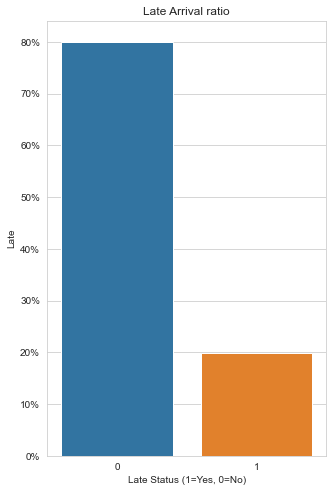

In [27]:
xLate, yLate = getCount(pandasDF["Late"])
myPlot(xLate, yLate, xLable="Late Status (1=Yes, 0=No)", yLable="% Percentage", title="Late Arrival ratio",figsize=(5,8),type='bar')

+ The above bar graph allows us to view the ratio of late flights to flights arrived on time where **0** means flight arrived early or on time and **1** means flight arrived late

In [28]:
print("The Correlation between the DepDelay and ArrDelay is >>>> ", StatsFlightData.stat.corr("DepDelay","ArrDelay"))

The Correlation between the DepDelay and ArrDelay is >>>>  0.9394056759019349


+ Now Let us do a summary of the time series data

<AxesSubplot:xlabel='DayofMonth', ylabel='count'>

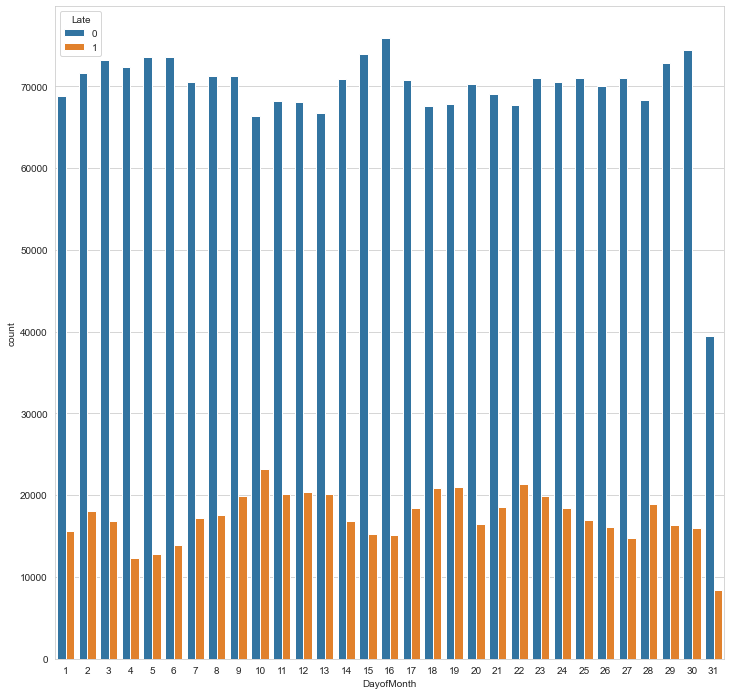

In [29]:
plt.subplots(figsize=(12,12))
sns.countplot(x='DayofMonth',hue='Late',data=pandasDF)

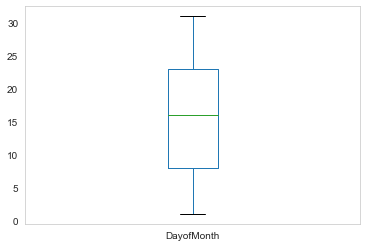

In [143]:
boxplot = pandasDF.boxplot(column=['DayofMonth'], grid = False)

+ From this we understand that most flight become **delayed** in the second quater of the month and very **less** delays occur at the last and first quater of the month

<AxesSubplot:xlabel='DayOfWeek', ylabel='count'>

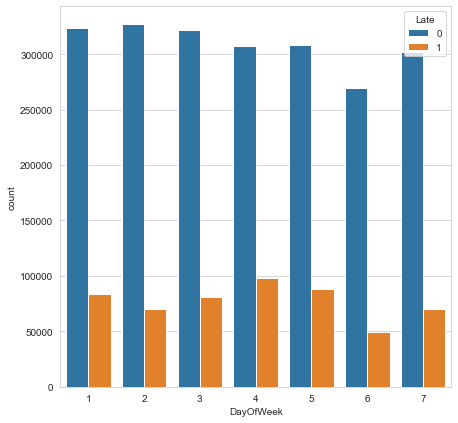

In [30]:
plt.subplots(figsize=(7,7))
sns.countplot(x='DayOfWeek',hue='Late',data=pandasDF)

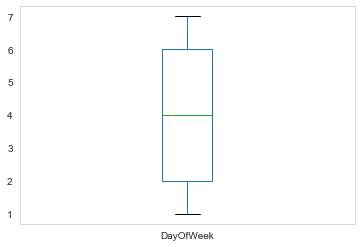

In [144]:
boxplot = pandasDF.boxplot(column=['DayOfWeek'], grid = False)

+ Most Delays occur on the fourth day of the week

<AxesSubplot:xlabel='count', ylabel='OriginAirportID'>

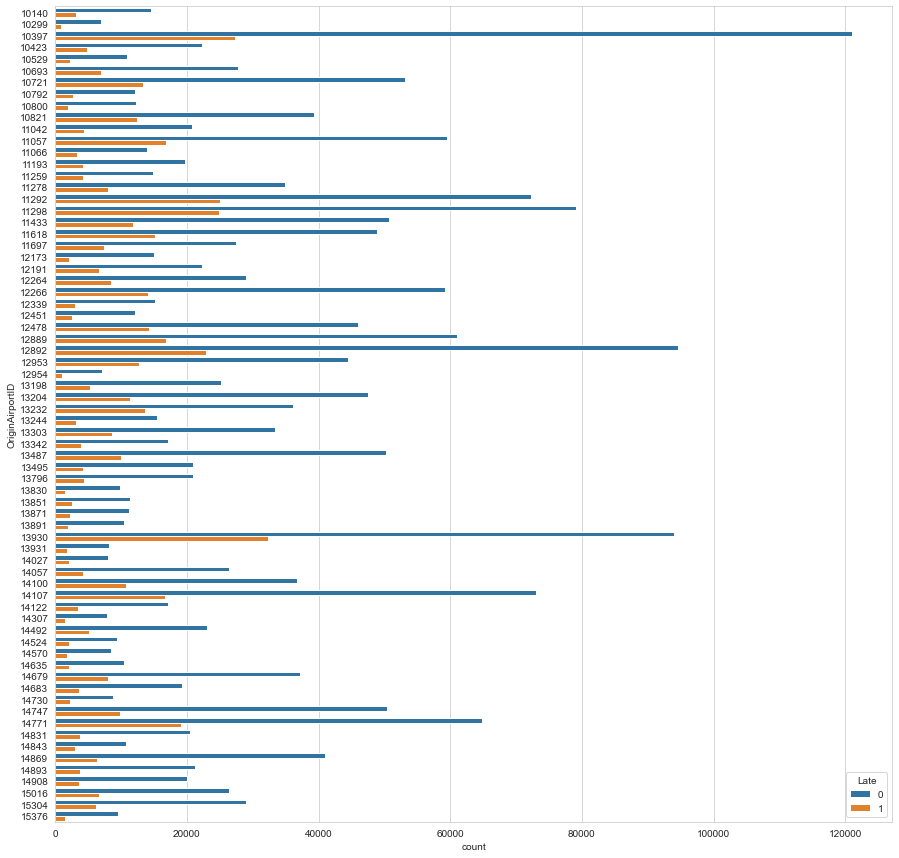

In [150]:
plt.subplots(figsize=(15,15))
sns.countplot(y='OriginAirportID',hue='Late',data=pandasDF)

+ From the above data we can conclude that the departure airport with ID **13930** is responsible for most of the departure delays

<AxesSubplot:xlabel='count', ylabel='DestAirportID'>

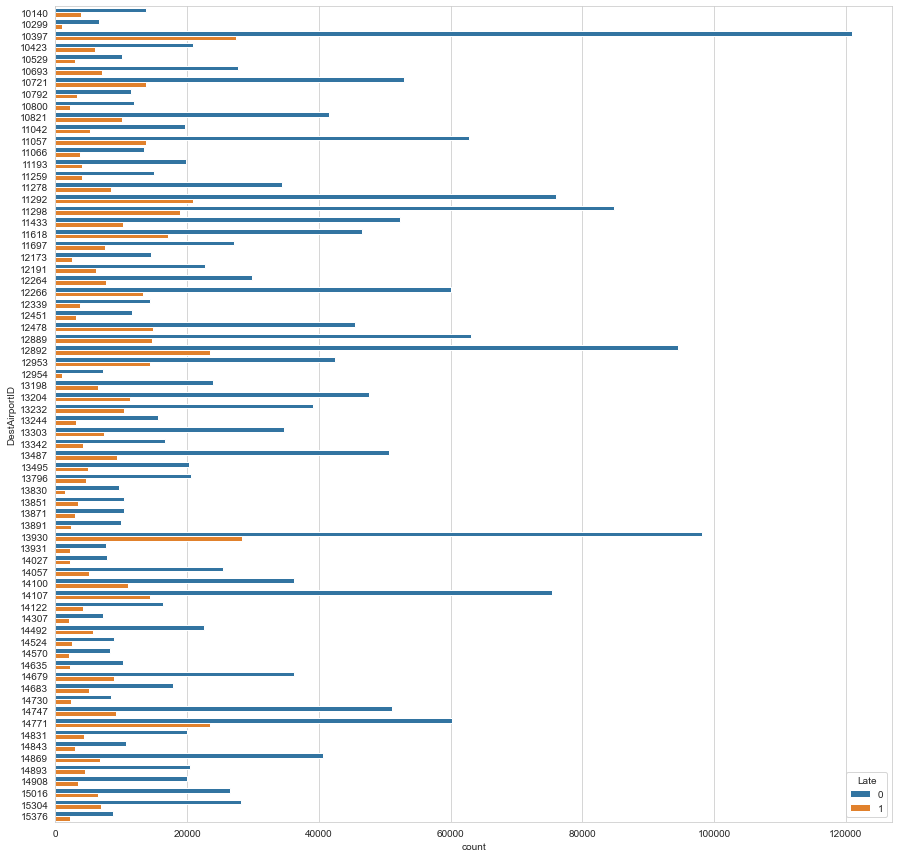

In [32]:
plt.subplots(figsize=(15,15))
sns.countplot(y='DestAirportID',hue='Late',data=pandasDF)

+ From the above data we can again conclude that the arrival airport with ID **<i>13930</i>** is responsible for most of the arrival delays also
+ **Therefore the airport with iD <i>13930</i> is reponisble for most flight delays**

+ Now We will view column wise summaries of the data in the column

In [123]:
flightsCleanData.describe('DayofMonth','DayOfWeek','DepDelay','ArrDelay').show()

+-------+------------------+------------------+------------------+------------------+
|summary|        DayofMonth|         DayOfWeek|          DepDelay|          ArrDelay|
+-------+------------------+------------------+------------------+------------------+
|  count|           2696983|           2696983|           2696983|           2696983|
|   mean|15.798996508320593| 3.900369412784582|10.613481805409972|  6.72087217457433|
| stddev| 8.801267199135454|1.9864582421701977| 36.04900147972999|38.578791794541594|
|    min|                 1|                 1|               -63|               -94|
|    max|                31|                 7|              1863|              1845|
+-------+------------------+------------------+------------------+------------------+



+ We shall conclude our stastical analysis with a correlation map of the comlumns

<AxesSubplot:>

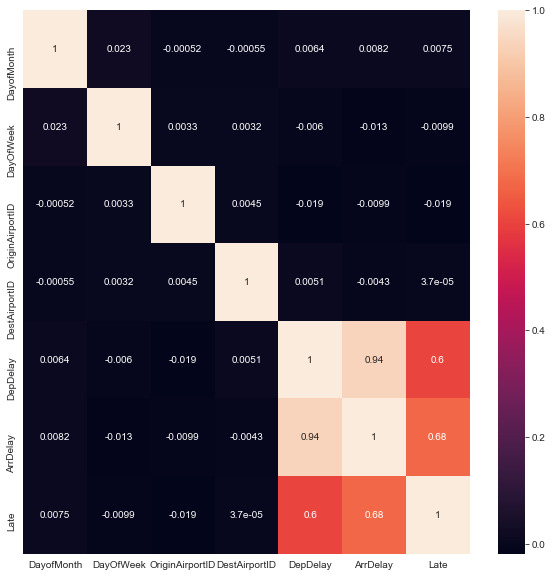

In [34]:
figure, axes = plt.subplots(figsize=(10,10))
sns.heatmap(pandasDF.corr(),annot=True,ax=axes)

# Classification

+ Splitting the processed data into training data and test data

In [35]:
#divide data, 70% for training, 30% for testing
dividedData = FinalFlightData.randomSplit([0.7, 0.3]) 
trainingData = dividedData[0] #index 0 = data training
testingData = dividedData[1] #index 1 = data testing
train_rows = trainingData.count()
test_rows = testingData.count()
print ("Training data rows:", train_rows, "; Testing data rows:", test_rows)

Training data rows: 1888119 ; Testing data rows: 808864


### Preparing training data

In [36]:
#define an assembler
assembler = VectorAssembler(inputCols = [
    "DayofMonth", "DayOfWeek","carrierIndex", "OriginAirportID_scaled", "DestAirportID_scaled", 
    "DepDelay"], outputCol="features")
trainingDataFinal = assembler.transform(trainingData).select(col("features"), col("Late").alias("label"))
trainingDataFinal.show(truncate=False, n=5)

+----------------------------------------------------------+-----+
|features                                                  |label|
+----------------------------------------------------------+-----+
|[1.0,1.0,9.0,0.04908326967150496,0.24694423223834988,27.0]|0    |
|[1.0,1.0,1.0,0.04908326967150496,0.29736440030557676,8.0] |0    |
|[1.0,1.0,9.0,0.04908326967150496,0.3917112299465241,16.0] |0    |
|[1.0,1.0,1.0,0.04908326967150496,0.5851795263559969,-1.0] |0    |
|[1.0,1.0,2.0,0.04908326967150496,0.604087089381207,-3.0]  |0    |
+----------------------------------------------------------+-----+
only showing top 5 rows



### Preparing testing data

In [37]:
testingDataFinal = assembler.transform(testingData).select(col("features"), col("Late").alias("trueLabel"))
testingDataFinal.show(5)

+--------------------+---------+
|            features|trueLabel|
+--------------------+---------+
|[1.0,1.0,1.0,0.04...|        0|
|[1.0,1.0,10.0,0.1...|        1|
|[1.0,1.0,2.0,0.21...|        0|
|[1.0,1.0,13.0,0.2...|        0|
|[1.0,1.0,5.0,0.22...|        0|
+--------------------+---------+
only showing top 5 rows



### Training our classifier using our training data
+ we are using RandomForrestClassifier as most of our data has no correlation as observed from the matrix earlier

In [38]:
#define our classifier
from pyspark.ml.classification import RandomForestClassifier

model = RandomForestClassifier(
    numTrees=3, maxDepth=5, seed=42, labelCol="label",featuresCol="features")
model = model.fit(trainingDataFinal)
print ("Classification model is trained!")

Classification model is trained!


### Predicting the test data using our test data on the trained model 

In [39]:
prediction = model.transform(testingDataFinal)
predictionFinal = prediction.select(
    "features", "prediction", "trueLabel")
predictionFinal.show(truncate=False, n=5)

+----------------------------------------------------------+----------+---------+
|features                                                  |prediction|trueLabel|
+----------------------------------------------------------+----------+---------+
|[1.0,1.0,1.0,0.04908326967150496,0.5840336134453782,0.0]  |0.0       |0        |
|[1.0,1.0,10.0,0.1768525592055004,0.446524064171123,96.0]  |1.0       |1        |
|[1.0,1.0,2.0,0.2173414820473644,0.22116119174942703,-4.0] |0.0       |0        |
|[1.0,1.0,13.0,0.22001527883880825,0.7087471352177235,-4.0]|0.0       |0        |
|[1.0,1.0,5.0,0.22001527883880825,0.8676470588235294,-6.0] |0.0       |0        |
+----------------------------------------------------------+----------+---------+
only showing top 5 rows



### Calculate our Models Performance

In [40]:
correctPrediction = predictionFinal.filter(
    predictionFinal['prediction'] == predictionFinal['trueLabel']).count()
totalData = predictionFinal.count()
print("correct prediction:", correctPrediction, ", total data:", 
      totalData, ", accuracy", correctPrediction/totalData)

correct prediction: 749387 , total data: 808864 , accuracy 0.9264684792499109


# Clustering Problem

+ We can't use the same data for our clustring algorithm as clustering algorithms aren't used for label prediction
+ We will be using another dataset

## Read file into dataFrame
Description for each column data:
- CustomerName: name of customer
- Age: age of customer (in year)
- MaritalStatus: (1=married, 0=not married)
- IncomeRange: income per year (in USD)
- Gender: (1=female, 2=male)
- TotalChildren: number of children customer has
- ChildrenAtHome: number of children living with customer (in the same home)
- Education: (1=high school, 2=bachelor, 3=master, 4=PhD, 5=Post-doc)
- Occupation: (0=unskilled manual work until 5=professional)
- HomeOwner: (1=owning a home, 0=not owning a home)
- Cars: number of car customer has

In [41]:
customersSchema = StructType([
  StructField("CustomerName", StringType(), False),
  StructField("Age", IntegerType(), False),
  StructField("MaritalStatus", IntegerType(), False),
  StructField("IncomeRange", IntegerType(), False),
  StructField("Gender", IntegerType(), False),
  StructField("TotalChildren", IntegerType(), False),
  StructField("ChildrenAtHome", IntegerType(), False),
  StructField("Education", IntegerType(), False),
  StructField("Occupation", IntegerType(), False),
  StructField("HomeOwner", IntegerType(), False),
  StructField("Cars", IntegerType(), False),
])

customers = spark.read.csv('dataset/customers.csv', 
                         schema=customersSchema, header=True)

customers.show(3)

+---------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+
|   CustomerName|Age|MaritalStatus|IncomeRange|Gender|TotalChildren|ChildrenAtHome|Education|Occupation|HomeOwner|Cars|
+---------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+
|    Aaron Adams| 42|            0|      50000|     0|            0|             0|        3|         2|        1|   1|
|Aaron Alexander| 40|            1|      50000|     0|            0|             0|        2|         2|        1|   2|
|    Aaron Allen| 63|            0|      25000|     0|            2|             1|        2|         1|        1|   2|
+---------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+
only showing top 3 rows



# Preprocessing The Data

+ Dropping the duplicate entries

In [42]:
#count the number of original data rows
n1 = customers.count()
print("number of original data rows: ", n1)
#count the number of data rows after deleting duplicated data
n2 = customers.dropDuplicates().count()
print("number of data rows after deleting duplicated data: ", n2)
n3 = n1 - n2
print("number of duplicated data: ", n3)

number of original data rows:  18508
number of data rows after deleting duplicated data:  18484
number of duplicated data:  24


In [43]:
customers =  customers.dropDuplicates()
n4 = customers.count()
print(n4)

18484


+ Counting the missing data

In [44]:
customers.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in customers.columns]).show()

+------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+
|CustomerName|Age|MaritalStatus|IncomeRange|Gender|TotalChildren|ChildrenAtHome|Education|Occupation|HomeOwner|Cars|
+------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+
|           0|  0|            0|          0|     0|            0|             0|        0|         0|        0|   0|
+------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+



+ There is no missing values so the dataset is ready to be normalized

# Normalization
+ We will be normalizing the IncomeRange and Age columns

In [45]:
print("This is the maximum of the column 'OriginAirportID': ")
customers.agg({'Age':'max'}).show()

print("This is the minimum of the column 'OriginAirportID': ")
customers.agg({'Age':'min'}).show()

print("This is the maximum of the column 'OriginAirportID': ")
customers.agg({'IncomeRange':'max'}).show()

print("This is the minimum of the column 'OriginAirportID': ")
customers.agg({'IncomeRange':'min'}).show()

This is the maximum of the column 'OriginAirportID': 
+--------+
|max(Age)|
+--------+
|     106|
+--------+

This is the minimum of the column 'OriginAirportID': 
+--------+
|min(Age)|
+--------+
|      36|
+--------+

This is the maximum of the column 'OriginAirportID': 
+----------------+
|max(IncomeRange)|
+----------------+
|          150000|
+----------------+

This is the minimum of the column 'OriginAirportID': 
+----------------+
|min(IncomeRange)|
+----------------+
|           25000|
+----------------+



In [46]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

columns_to_scale = ["Age", "IncomeRange"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale]
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in columns_to_scale]
pipeline = Pipeline(stages=assemblers + scalers)
scalerModel = pipeline.fit(customers)
scaledcustomersData = scalerModel.transform(customers)
scaledcustomersData.show(5)

+---------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+-------+---------------+--------------------+--------------------+
|   CustomerName|Age|MaritalStatus|IncomeRange|Gender|TotalChildren|ChildrenAtHome|Education|Occupation|HomeOwner|Cars|Age_vec|IncomeRange_vec|          Age_scaled|  IncomeRange_scaled|
+---------------+---+-------------+-----------+------+-------------+--------------+---------+----------+---------+----+-------+---------------+--------------------+--------------------+
| Aaron Campbell| 49|            0|      75000|     0|            0|             0|        5|         5|        1|   1| [49.0]|      [75000.0]|[0.18571428571428...|[0.39999999999999...|
|    Aaron Hayes| 58|            1|     100000|     0|            1|             0|        3|         2|        1|   1| [58.0]|     [100000.0]|[0.3142857142857143]|               [0.6]|
|Aidan Alexander| 44|            1|      50000|     0|            1|  

+ Dropping all unecessary columns

In [47]:
FinalCustomerData = scaledcustomersData.select(
    "CustomerName", "Age_scaled", "MaritalStatus", "IncomeRange_scaled", 
    "Gender","TotalChildren","ChildrenAtHome","Education","Occupation","HomeOwner","Cars")
FinalCustomerData.show(5)

+---------------+--------------------+-------------+--------------------+------+-------------+--------------+---------+----------+---------+----+
|   CustomerName|          Age_scaled|MaritalStatus|  IncomeRange_scaled|Gender|TotalChildren|ChildrenAtHome|Education|Occupation|HomeOwner|Cars|
+---------------+--------------------+-------------+--------------------+------+-------------+--------------+---------+----------+---------+----+
| Aaron Campbell|[0.18571428571428...|            0|[0.39999999999999...|     0|            0|             0|        5|         5|        1|   1|
|    Aaron Hayes|[0.3142857142857143]|            1|               [0.6]|     0|            1|             0|        3|         2|        1|   1|
|Aidan Alexander|[0.11428571428571...|            1|[0.19999999999999...|     0|            1|             1|        5|         2|        1|   0|
|     Alan Zheng|[0.41428571428571...|            1|[0.19999999999999...|     0|            3|             0|        2|     

# Statistical Summaries on the data for clustering, also known as EDA

+ Converting the pyspark dataframe to pandas dataframe so it becomes easier to plot

In [59]:
pandascustomers = customers.toPandas()
pandascustomers.head(5)

,CustomerName,Age,MaritalStatus,IncomeRange,Gender,TotalChildren,ChildrenAtHome,Education,Occupation,HomeOwner,Cars
0,Aaron Campbell,49,0,75000,0,0,0,5,5,1,1
1,Aaron Hayes,58,1,100000,0,1,0,3,2,1,1
2,Aidan Alexander,44,1,50000,0,1,1,5,2,1,0
3,Alan Zheng,65,1,50000,0,3,0,2,2,1,2
4,Andrea Campbell,54,0,25000,1,1,0,5,3,1,0


+ First we shall draw the correlation matreix to find out which columns are most realted to each other

<AxesSubplot:>

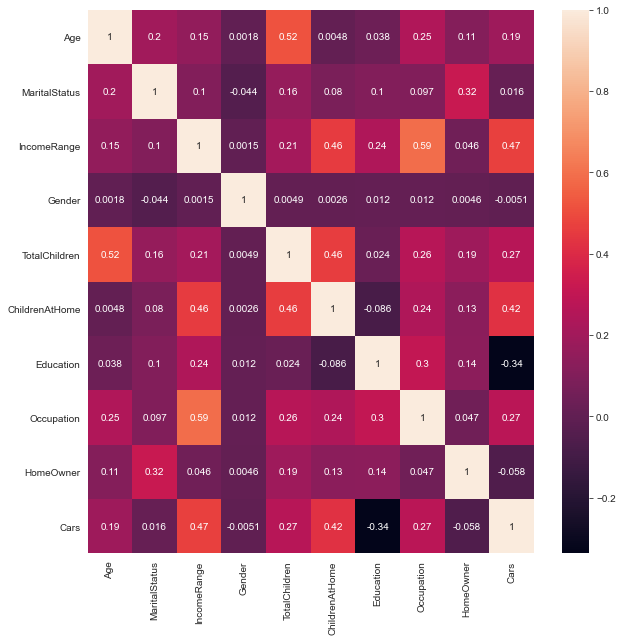

In [60]:
figure, axes = plt.subplots(figsize=(10,10))
sns.heatmap(pandascustomers.corr(),annot=True,ax=axes)

+ **Total Children** and **age** have high correlation and can be inferred that these columns are related to each other the most

In [77]:
numberOfPeopleWithNoChildren = pandascustomers[pandascustomers['TotalChildren']==0]
numberOfPeopleWithNoChildren.shape

(5165, 11)

+ There are 5165 people in our data with no children
+ This information can be better understood with a bar graph showing how many people have kids and how many do not

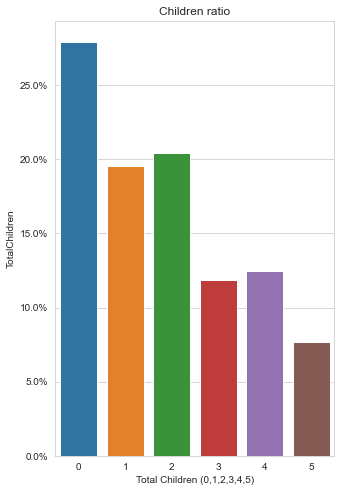

In [124]:
xTotalChild, yTotalChild = getCount(pandascustomers['TotalChildren'])
myPlot(xTotalChild, yTotalChild, xLable="Total Children (0,1,2,3,4,5)",\
       yLable="% Percentage", title="Children ratio",figsize=(5,8),type='bar')

+ Now we can plot how many of these people have children at home
+ We can infer that most people have **no kids** at all but those who choose to have kids have most likely **two kids**

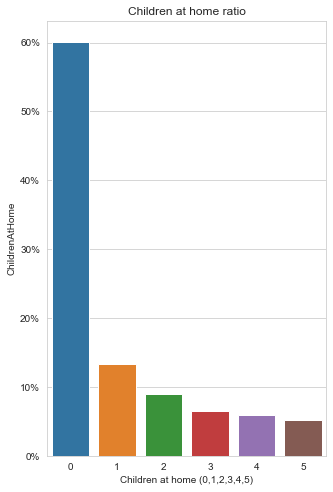

In [125]:
xChild, yChild = getCount(pandascustomers['ChildrenAtHome'])
myPlot(xChild, yChild, xLable="Children at home (0,1,2,3,4,5)",\
       yLable="% Percentage", title="Children at home ratio",figsize=(5,8),type='bar')

+ What can be understood from this data is that most people have significant gaps in having their second kid so the first kid dosent stay at home anymore, this is inferred by seeing the people who have had kids

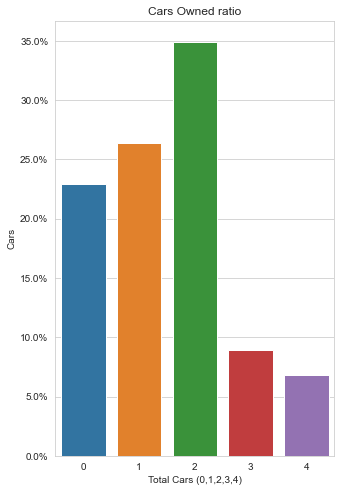

In [128]:
xCars, yCars = getCount(pandascustomers['Cars'])
myPlot(xCars,yCars, xLable="Total Cars (0,1,2,3,4)",\
       yLable="% Percentage", title="Cars Owned ratio",figsize=(5,8),type='bar')

+ Most People have **two** cars

<AxesSubplot:xlabel='count', ylabel='Age'>

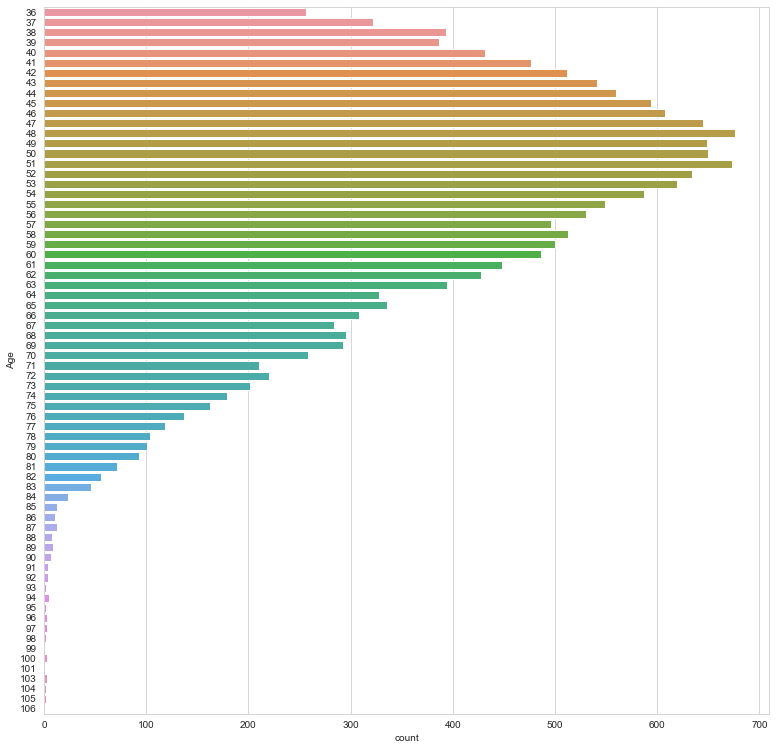

In [132]:
plt.subplots(figsize=(13,13))
sns.countplot(y='Age',data=pandascustomers)

+ A majority of the people in the data belong in the age bracket of **46 to 53**

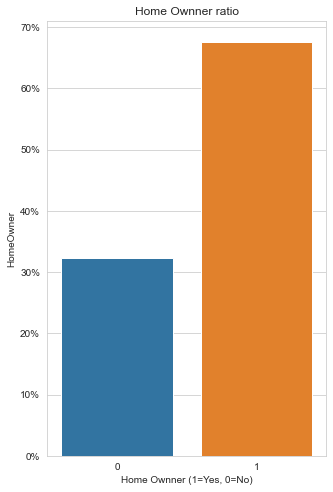

In [101]:
xLate, yLate = getCount(pandascustomers["HomeOwner"])
myPlot(xLate, yLate, xLable="Home Ownner (1=Yes, 0=No)", yLable="% Percentage", \
       title="Home Ownner ratio",figsize=(5,8),type='bar')

+ A majority of the people in our dataset **own a home**

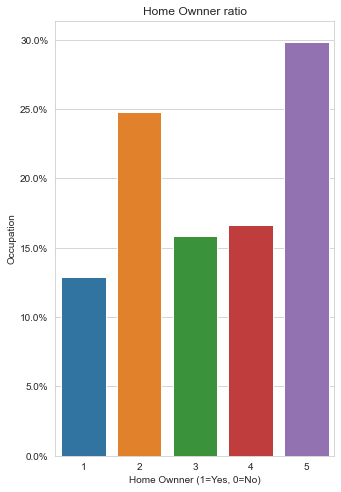

In [104]:
xLate, yLate = getCount(pandascustomers["Occupation"])
myPlot(xLate, yLate, xLable="Occupation (0,1,2,3,4,5)", yLable="% Percentage",\
       title="Occupation ratio",figsize=(5,8),type='bar')

+ Majority of the people in our dataset belong to occupation **5**

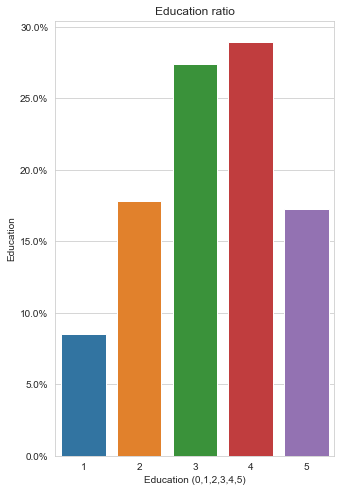

In [107]:
xLate, yLate = getCount(pandascustomers["Education"])
myPlot(xLate, yLate, xLable="Education (0,1,2,3,4,5)", yLable="% Percentage",\
       title="Education ratio",figsize=(5,8),type='bar')

+ Most of the people in our dataset have been educated in field **4**

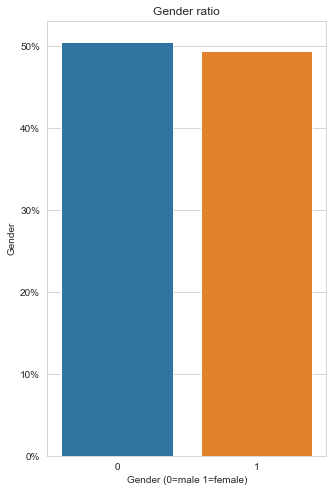

In [141]:
xLate, yLate = getCount(pandascustomers["Gender"])
myPlot(xLate, yLate, xLable="Gender (0=male 1=female)", yLable="% Percentage",\
       title="Gender ratio",figsize=(5,8),type='bar')

+ There are more males in the dataset but not by much, the data is split evenly between both genders

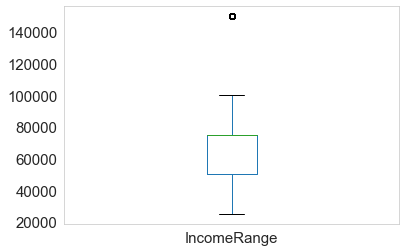

In [136]:
boxplot = pandascustomers.boxplot(column=['IncomeRange'], grid = False,fontsize=15)

+ Most people are in the income range of 50000  to 70000

## Preparing the data for applying the clustering algorithm

In [50]:
#define assembler
assembler = VectorAssembler(inputCols = [
    "Age_scaled", "MaritalStatus", "IncomeRange_scaled", 
    "Gender","TotalChildren","ChildrenAtHome","Education","Occupation","HomeOwner","Cars"], 
                            outputCol="features")
data = assembler.transform(FinalCustomerData).select('CustomerName', 'features')
data.show(truncate = False, n=5)

+---------------+-------------------------------------------------------------------------+
|CustomerName   |features                                                                 |
+---------------+-------------------------------------------------------------------------+
|Aaron Campbell |[0.18571428571428572,0.0,0.39999999999999997,0.0,0.0,0.0,5.0,5.0,1.0,1.0]|
|Aaron Hayes    |[0.3142857142857143,1.0,0.6,0.0,1.0,0.0,3.0,2.0,1.0,1.0]                 |
|Aidan Alexander|[0.11428571428571428,1.0,0.19999999999999998,0.0,1.0,1.0,5.0,2.0,1.0,0.0]|
|Alan Zheng     |[0.41428571428571426,1.0,0.19999999999999998,0.0,3.0,0.0,2.0,2.0,1.0,2.0]|
|Andrea Campbell|[0.2571428571428571,0.0,0.0,1.0,1.0,0.0,5.0,3.0,1.0,0.0]                 |
+---------------+-------------------------------------------------------------------------+
only showing top 5 rows



## Create k-Means clustering model

In [51]:
#define kMeans clustering algorithm
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
kmeans = KMeans(
    featuresCol=assembler.getOutputCol(), 
    predictionCol="cluster", k=5)
model = kmeans.fit(data)
print ("Model is successfully trained!")

Model is successfully trained!


## Print centroid for each cluster

In [52]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[0.26679017 0.63066316 0.66441234 0.49343401 3.21897571 3.93466842
 3.20617203 4.08273145 0.76362443 2.82206172]
[0.2078454  0.44468972 0.39406426 0.50551876 0.46357616 0.11160167
 4.25214619 4.08879078 0.59504538 0.95560461]
[0.20826773 0.45458506 0.19455456 0.48573296 0.87453714 0.1570464
 2.1272054  1.89501198 0.54672185 1.58091919]
[0.23565812 0.58027523 0.18374836 0.49246396 1.91743119 0.92791612
 3.71952818 1.92791612 0.81454784 0.52293578]
[0.41111581 0.65061861 0.41065089 0.49381388 3.36982249 0.690156
 3.36471221 4.4464766  0.74072082 1.72942442]


## Cluster the data

In [53]:
prediction = model.transform(data)#cluster given data
prediction.groupBy("cluster").count().orderBy("cluster").show()#count members in each cluster
prediction.select('CustomerName', 'cluster').show(5)#show several clustered data

+-------+-----+
|cluster|count|
+-------+-----+
|      0| 3046|
|      1| 4077|
|      2| 4591|
|      3| 3052|
|      4| 3718|
+-------+-----+

+---------------+-------+
|   CustomerName|cluster|
+---------------+-------+
| Aaron Campbell|      1|
|    Aaron Hayes|      2|
|Aidan Alexander|      3|
|     Alan Zheng|      2|
|Andrea Campbell|      1|
+---------------+-------+
only showing top 5 rows



# Visualizing the results

## For the classification problem
+ we can infer how the model performed using the following confusion matrix.

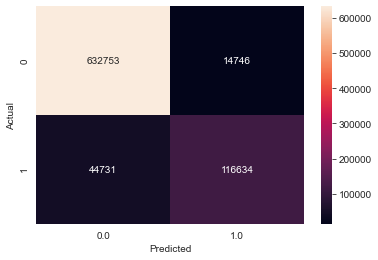

In [54]:
pandaspredictionFinal = predictionFinal.toPandas()

confusion_matrix = pd.crosstab(pandaspredictionFinal['trueLabel'], pandaspredictionFinal['prediction'], rownames=['Actual'], colnames=['Predicted'])
#plt.figure(figsize=(10,10))
#sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

**From this we conclude the following**
+ **True Positive count  : 116634**
+ **False Positive count : 14746**
+ **True Negative count  : 632753**
+ **False Negative count : 44731**

## For the clustering problem
+ we can infer how the model has clustered our data

In [55]:
pandasClusterpredictionFinal = prediction.toPandas()
pandasClusterpredictionFinal.head(5)

,CustomerName,features,cluster
0,Aaron Campbell,"[0.18571428571428572, 0.0, 0.39999999999999997...",1
1,Aaron Hayes,"[0.3142857142857143, 1.0, 0.6, 0.0, 1.0, 0.0, ...",2
2,Aidan Alexander,"[0.11428571428571428, 1.0, 0.19999999999999998...",3
3,Alan Zheng,"[0.41428571428571426, 1.0, 0.19999999999999998...",2
4,Andrea Campbell,"[0.2571428571428571, 0.0, 0.0, 1.0, 1.0, 0.0, ...",1


In [56]:
pandasClusterpredictionFinal.cluster.unique()

array([1, 2, 3, 4, 0])

+ There are 5 clusters '0','1','2','3' and '4' and each person has been clustered into one of these groups based on the features they had

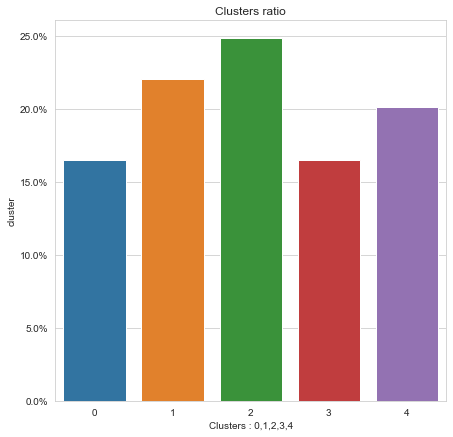

In [57]:
xcluster, ycluster = getCount(pandasClusterpredictionFinal["cluster"])
myPlot(xcluster, ycluster, xLable="Clusters : 0,1,2,3,4", yLable="% Percentage", title="Clusters ratio",figsize=(7,7),type='bar')

+ **We conclude that the cluster with the highest concentration of data points was cluster group '2'**

# Thank You
### @Vasanthagokul S - 1801247